In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import norm
import pandas as pd

# Données 

In [4]:
y = np.array([21,20,15])
n = np.array([48,34,21])
Z = np.array([10,30,50])

data_air = np.zeros((3,3))
data_air[:,0] = y
data_air[:,1] = n
data_air[:,2] = Z

print("------------------ Données Air -----------------------")
print(pd.DataFrame(data_air, columns= ["illness", "nb_group", "NO2"]))
print("--------------------------------------------------")

------------------ Données Air -----------------------
   illness  nb_group   NO2
0     21.0      48.0  10.0
1     20.0      34.0  30.0
2     15.0      21.0  50.0
--------------------------------------------------


# Metropolis Hastings sur les 5 paramètres du modèle. 

On simule la distribution de 5 paramètres $(\theta_1, \theta_2, X_1, X_2, X_3)$ selon la loi a posteriori du modèle. 

In [11]:
def algo_metropolis_Air(nchain, obs, sigma_prop_theta1, sigma_prop_theta2, sigma_prop_X,  thinning_step = 1, nb_burn = 0, Init = np.zeros((1,5))):

    chain = np.zeros((nchain+1,5))  #Création de la chaîne de Markov
    
    index_thinning = np.arange(start=0, stop=nchain+1 - nb_burn, step=thinning_step)  #Pour élaguer la chaîne à la fin de l'algo

    compt_acc = nchain # c'est le compteur d'acceptation, on l'initialise à la taille de la chaîne car on aura seulement la phase de rejet en fin d'algo donc on fera compt_acc - 1 à chaque rejet

    y = obs[:,0]
    n = obs[:,1]
    Z = obs[:,2]

    #hyperparamètres

    alpha = 4.48
    beta = 0.76
    sigma2 = 81.44

#Initialisation 
    
    chain[0,:] = Init


#Génération de la chaîne
    

    for i in range(nchain):

        index_coord = rnd.choice(np.arange(5))  #On choisit aléatoirement la coordonnée pour laquelle on propose un candidat
        index_nocoord = np.where(np.arange(5) != index_coord)  #On récupère les indices des coordonnées non modifiées

    # Ici on a un peu de IF afin de mettre différentes variance pour le noyau de proposition normal selon la coordonnées modifiée

        if(index_coord == 0):
            sigma_prop = sigma_prop_theta1  
        else:
            if(index_coord == 1):
                sigma_prop = sigma_prop_theta2
            else:
                sigma_prop = sigma_prop_X   # même sigma pour les 3 Xi
        
        

        prop = rnd.normal(chain[i,index_coord],sigma_prop)   #Noyau de proposition symétrique

        chain[i+1,index_coord] = prop   #On a besoin de "savoir" quelle coordonnées on a modifié donc on met la coord modifiée dans la chaîne comme si on acceptait la proposition
        chain[i+1,index_nocoord] = chain[i,index_nocoord]  #On fait de même pour les coord non modif, celles-ci auraient été ajoutée de toute manière

        theta1, theta2, X1,X2,X3 = chain[i,:]   #On récupère les 5 paramètres précédents
        theta1_prop, theta2_prop, X1_prop,X2_prop,X3_prop = chain[i+1,:]  # On récupère les 5 "nouveaux" paramètres, en réalité il n'y en a qu'un de nouveau mais bon c'est + lisible comme ça
        # On récupère les valeurs des différents pi 
        p1,p2,p3 = np.array([1/(1 + np.exp(-(theta1 + theta2*X1)))   ,   1/(1 + np.exp(-(theta1 + theta2*X2)))    ,  1/(1 + np.exp(-(theta1 + theta2*X3)))]) 
        p1_prop, p2_prop,p3_prop = np.array([1/(1 + np.exp(-(theta1_prop + theta2_prop*X1_prop)))   \
            ,   1/(1 + np.exp(-(theta1_prop + theta2_prop*X2_prop)))    ,  1/(1 + np.exp(-(theta1_prop + theta2_prop*X3_prop)))]) # Les valeurs des pi "proposés"
        
        
        
        g_Y = np.array([p1**n[0]*(1-p1)**(n[0]-y[0]),  p2**n[1]*(1-p2)**(n[1]-y[1])   ,  p3**n[2]*(1-p3)**(n[2]-y[2])])  #La vraisemblance des observations, on aura besoin d'une somme donc on met ça dans un vecteur
        g_theta1 = norm.pdf(theta1,0,np.sqrt(1000))                #Les différentes densité a priori des paramètres             
        g_theta2 = norm.pdf(theta2,0,np.sqrt(1000))
        g_X1 = norm.pdf(X1, alpha + beta*Z[0],np.sqrt(sigma2))
        g_X2 = norm.pdf(X2, alpha + beta*Z[1],np.sqrt(sigma2))
        g_X3 = norm.pdf(X3, alpha + beta*Z[2],np.sqrt(sigma2))

        prob_inf = np.sum(np.log(g_Y)) + np.log(g_theta1) + np.log(g_theta2) + np.log(g_X1) + np.log(g_X2) + np.log(g_X3)  #densité a posteriori // On a supposé l'indépendance 2 à 2 des 5 paramètres


        #Même chose pour les candidats

        g_Y_new = np.array([p1_prop**n[0]*(1-p1_prop)**(n[0]-y[0]),  p2_prop**n[1]*(1-p2_prop)**(n[1]-y[1])   ,  p3_prop**n[2]*(1-p3_prop)**(n[2]-y[2])])
        g_theta1_new = norm.pdf(theta1_prop,0,np.sqrt(1000))
        g_theta2_new = norm.pdf(theta2_prop,0,np.sqrt(1000))
        g_X1_new = norm.pdf(X1_prop, alpha + beta*Z[0],np.sqrt(sigma2))
        g_X2_new = norm.pdf(X2_prop, alpha + beta*Z[1],np.sqrt(sigma2))
        g_X3_new = norm.pdf(X3_prop, alpha + beta*Z[2],np.sqrt(sigma2))

        prob_sup = np.sum(np.log( g_Y_new)) + np.log(g_theta1_new) + np.log(g_theta2_new) + np.log(g_X1_new) + np.log(g_X2_new) + np.log(g_X3_new)


        #print(prob_inf)
        #print(prob_sup)

        alpha_acc = np.min((0, prob_sup - prob_inf))

        #print(alpha_acc)

        log_U = np.log(rnd.uniform())

        if (log_U > alpha_acc):
            chain[i+1,index_coord] = chain[i,index_coord]   #On a seulement l'étape de rejet car on a déjà accepté la nouvelle proposition pour les besoins de l'algo
            compt_acc -= 1


    chain = chain[np.arange(nb_burn, nchain+1),:]  # Période de burn
    chain = chain[index_thinning,:]   #Elagage de la chaîne
    if (nchain % int(nchain/4)):
        print("Simulation {} terminée")
    return(chain, compt_acc/nchain)



In [40]:
CHAIN, compt_acc = algo_metropolis_Air(70000, data_air, 0.5, 0.02, 15 , thinning_step=10, nb_burn=2000)  #meilleurs sigma actuels : 0.5, 0.02, 15

In [41]:
print("--------------------------------------------------")
print(f"La probabilité de rejet de l'algorithme est de {compt_acc}.")

--------------------------------------------------
La probabilité de rejet de l'algorithme est de 0.4532.


In [43]:
THETA1 = CHAIN[:,0]
THETA2 = CHAIN[:,1]
X1 = CHAIN[:,2]
X2 = CHAIN[:,3]
X3 = CHAIN[:,4]

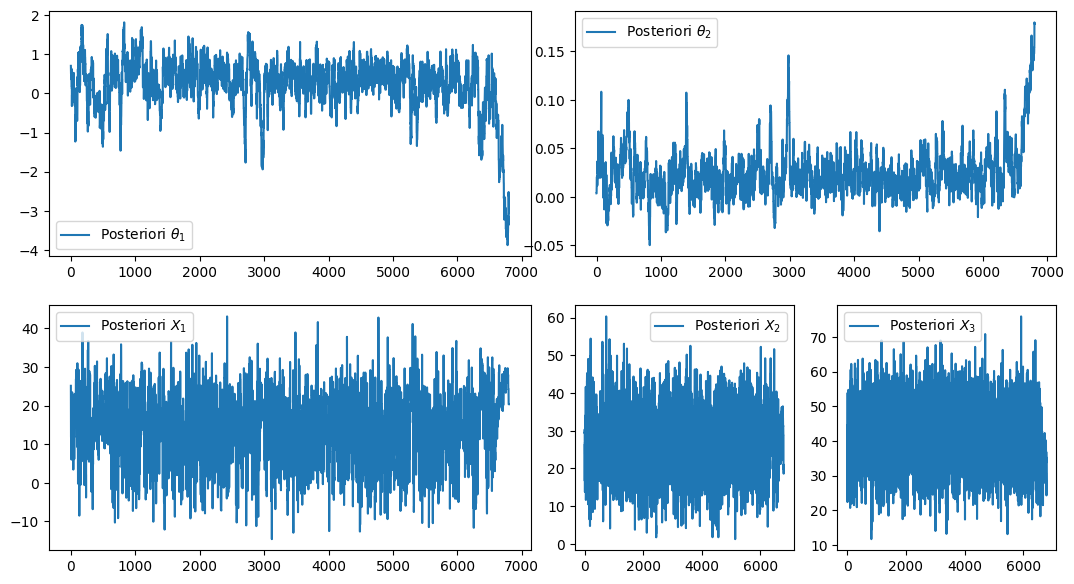

In [44]:
fig, ax = plt.subplot_mosaic([["A","A", "B","B"], ["C","C", "D", "F"]], figsize = (13, 7))

ax["A"].plot(THETA1, label= r"Posteriori $\theta_1$")
ax["A"].legend()
ax["B"].plot(THETA2, label= r"Posteriori $\theta_2$")
ax["B"].legend()
ax["C"].plot(X1, label = r"Posteriori $X_1$")
ax["C"].legend()
ax["D"].plot(X2, label= r"Posteriori $X_2$")
ax["D"].legend()
ax["F"].plot(X3, label= r"Posteriori $X_3$")
ax["F"].legend()

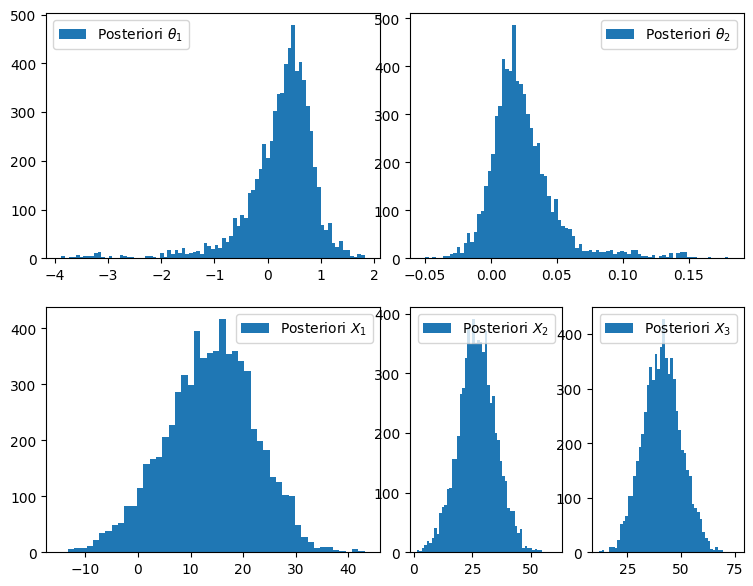

In [45]:
fig, ax = plt.subplot_mosaic([["A","A", "B","B"], ["C","C", "D", "F"]], figsize = (9, 7))

ax["A"].hist(THETA1, bins= 'auto', label= r"Posteriori $\theta_1$");
ax["A"].legend()
ax["B"].hist(THETA2, bins= 'auto', label= r"Posteriori $\theta_2$");
ax["B"].legend()
ax["C"].hist(X1, bins= 'auto', label= r"Posteriori $X_1$");
ax["C"].legend()
ax["D"].hist(X2, bins= 'auto', label= r"Posteriori $X_2$");
ax["D"].legend()
ax["F"].hist(X3, bins= 'auto', label= r"Posteriori $X_3$");
ax["F"].legend()

In [46]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de Theta1 {round(np.mean(THETA1), 2)} et variance de la loi a posteriori {round(np.std(THETA1), 2)}")
print(f"Estimateur en moyenne de Theta2 {round(np.mean(THETA2),2)} et variance de la loi a posteriori {round(np.std(THETA2),2)}")
print(f"Estimateur en moyenne de X1 {round(np.mean(X1),2)} et variance de la loi a posteriori {round(np.std(X1),2)}")
print(f"Estimateur en moyenne de X2 {round(np.mean(X2),2)} et variance de la loi a posteriori {round(np.std(X2),2)}")
print(f"Estimateur en moyenne de X3 {round(np.mean(X3),2)} et variance de la loi a posteriori {round(np.std(X3),2)}")


-------------------------------------------------------------------------------
Estimateur en moyenne de Theta1 0.24 et variance de la loi a posteriori 0.68
Estimateur en moyenne de Theta2 0.02 et variance de la loi a posteriori 0.03
Estimateur en moyenne de X1 13.75 et variance de la loi a posteriori 8.54
Estimateur en moyenne de X2 27.08 et variance de la loi a posteriori 8.02
Estimateur en moyenne de X3 41.16 et variance de la loi a posteriori 8.81


In [32]:
#Probabilité des binomial pour chaque groupe  
P1 = 1/(1+np.exp(-(THETA1 + THETA2*X1)))
P2 = 1/(1+np.exp(-(THETA1 + THETA2*X2)))
P3 = 1/(1+np.exp(-(THETA1 + THETA2*X3)))

In [33]:
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de la probabilité P1 {round(np.mean(P1),2)} et sa variance a posteriori {round(np.std(P1),2)}")
print(f"Estimateur en moyenne de la probabilité P2 {round(np.mean(P2),2)} et sa variance a posteriori {round(np.std(P2),2)}")
print(f"Estimateur en moyenne de la probabilité P3 {round(np.mean(P3),2)} et sa variance a posteriori {round(np.std(P3),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de la probabilité P1 0.64 et sa variance a posteriori 0.05
Estimateur en moyenne de la probabilité P2 0.71 et sa variance a posteriori 0.05
Estimateur en moyenne de la probabilité P3 0.77 et sa variance a posteriori 0.07


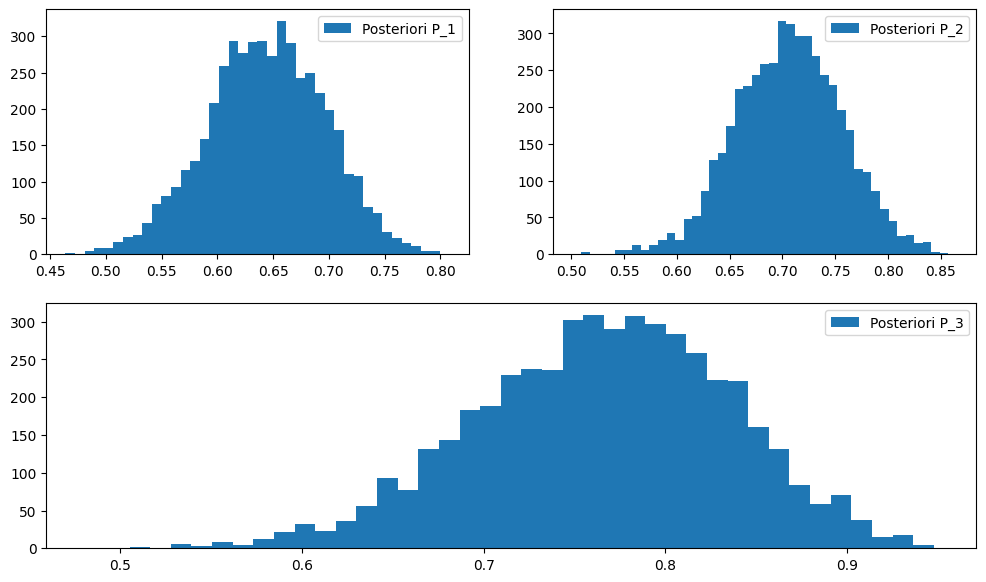

In [35]:
fig, ax = plt.subplot_mosaic([["A","B"], ["C", "C"]], figsize = (12, 7))
ax["A"].hist(P1, bins = "auto", label = r"Posteriori P_1")
ax["A"].legend()


ax["B"].hist(P2, bins = "auto", label = r"Posteriori P_2")
ax["B"].legend()


ax["C"].hist(P3, bins = "auto", label = r"Posteriori P_3")
ax["C"].legend()

**L'algorithme de Métropolis-Hastings peine à converger, peut-être que le nombre de paramètres est trop important. De plus, les fortes dépendances qu'on peut avoir sur les paramètres $\theta$ rendent l'exploration de l'espace plus difficile. Pour améliorer cela on utilise un échantillonneur de Gibbs.**